In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.ops import gen_audio_ops as audio_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

import librosa
import numpy as np
import scipy.signal
import scipy.io.wavfile as wavfile
import tensorflow as tf
import os, sys

from matplotlib import pyplot as plt
from tensorflow.python.ops import io_ops
from tf_speech_commands import input_data, models

try:
    from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
except ImportError:
    frontend_op = None
    
from rune_py import Fft, NoiseFiltering
import subprocess
    
tf.__version__

'1.15.2'

In [2]:
status = subprocess.run(["git", "rev-parse", "--show-toplevel"], stdout=subprocess.PIPE, check=True)

RUNE_PROJECT_ROOT = Path(status.stdout.decode("utf-8").strip())
EXAMPLE_DIR = RUNE_PROJECT_ROOT / "examples"

NameError: name 'Path' is not defined

In [2]:
fft = Fft()
noise_filtering = NoiseFiltering()

fft.sample_rate = 16000
noise_filtering.smoothing_bits = 10
noise_filtering.even_smoothing = 0.025
noise_filtering.odd_smoothing = 0.06
noise_filtering.min_signal_remaining = 0.05
noise_filtering.strength = 0.95
noise_filtering.offset = 80.0
noise_filtering.gain_bits = 21




In [3]:
sample_rate = 16000
window_size_samples = 480
window_stride_samples = 320
num_channels = 40
lower_band_limit = 0.0
upper_band_limit = 7999.0
min_signal_remaining=0.05
smoothing_bits=10
even_smoothing=0.025
odd_smoothing=0.06
enable_pcan=True
pcan_strength=0.95
pcan_offset=80.0
gain_bits=21
scale_shift=6
enable_log=True

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

window_size_ms = window_size_samples*1000/sample_rate
window_step_ms = window_stride_samples*1000/sample_rate

with tf.compat.v1.get_default_graph().name_scope('data'):
    wav_filename_placeholder_ = tf.compat.v1.placeholder(tf.string, [], name='wav_filename')
    num_channels_placeholder_ = tf.compat.v1.placeholder(tf.int16, [], name='wav_filename')
    # wav_content_placeholder = tf.placeholder(tf.int16, shape=(None, 1)) # TODO: find the shape of the wav data

    # Read WAV
    wav_loader = io_ops.read_file(wav_filename_placeholder_)

    # Decode a 16-bit PCM WAV file to a float tensor (between -1, +1)
    wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1, desired_samples=sample_rate)

    # Extracts a 1-second slice (since there are sample_rate samples) from a tensor: (input, begin, size)
    time_shift_offset_placeholder_ = tf.compat.v1.placeholder(tf.int32, shape=[2], name='time_shift_offset')
    sliced_foreground = tf.slice(wav_decoder.audio, time_shift_offset_placeholder_, [sample_rate, -1])

    f32_input = tf.multiply(sliced_foreground, 32768)
    int16_input = tf.cast(f32_input, tf.int16)

    int16_input_shape = tf.shape(int16_input)

    micro_frontend = frontend_op.audio_microfrontend(int16_input,  sample_rate=16000, 
        # WINDOWING
        window_size=window_size_ms, window_step=window_step_ms, num_channels=num_channels, 

        # MEL
        upper_band_limit=upper_band_limit, lower_band_limit=lower_band_limit,

        # SMOOTHING
        min_signal_remaining=min_signal_remaining, smoothing_bits=smoothing_bits, 
        even_smoothing=even_smoothing, odd_smoothing=odd_smoothing,

        # PCAN
        enable_pcan=enable_pcan, pcan_strength=pcan_strength, pcan_offset=pcan_offset, gain_bits=gain_bits,

        # LOG
        enable_log=enable_log,

        # SCALE
        scale_shift=scale_shift,

                                                     out_scale=1,
                                                     out_type=tf.float32)

    output_ = tf.multiply(micro_frontend, (10.0 / 256.0))
    #output_ = tf.multiply(micro_frontend, 1.0)

def compute(wav_filename):
    


    sample_rate, voice_signal = wavfile.read(wav_filename)
    voice_signal_normalised = (voice_signal-np.min(voice_signal))/(np.max(voice_signal)-np.min(voice_signal))
    voice_signal_f32 = voice_signal_normalised*32768

    input_dict = {wav_filename_placeholder_: wav_filename, time_shift_offset_placeholder_: [0, 0]}
    # Run the graph to produce the output audio.
    with tf.Session() as sess:
        [tf_micro_frontend, input_shape, tf_fg, tf_f32_input] = sess.run([output_, int16_input_shape, 
                                                                     sliced_foreground, f32_input], 
                                                                    feed_dict=input_dict)
    return tf_micro_frontend

In [4]:
yes

NameError: name 'yes' is not defined

In [28]:
def get_model_details():
    
        # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(
        model_path="/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/model_2048_up_down_right_left.tflite")
        #model_path="/Users/meelislootus/Documents/hotg/rune/examples/microspeech/model.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return input_details, output_details


def run_tflite_model(input_spectrogram):

    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(
        model_path="/Users/meelislootus/Documents/hotg/rune_new2/rune/examples/microspeech/model_2048_up_down_right_left.tflite")
        #model_path="/Users/meelislootus/Documents/hotg/rune/examples/microspeech/model.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on input data.
    interpreter.set_tensor(input_details[0]['index'], input_spectrogram)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [32]:


#output = (255*(output-np.min(output))/(np.max(output)-np.min(output))-128).astype(np.int8)

input_details, output_details = get_model_details()

input_scale, input_zero_point = input_details[0]["quantization"]

yes_dir = "/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/up"
no_dir = "/Users/meelislootus/Documents/hotg/tflite_models/microspeech/dataset/no"
yes_list = os.listdir(yes_dir)
no_list = os.listdir(no_dir)

tf_result_list = []
rune_result_list = []

for yes in yes_list[0:5]:

    output = compute(os.path.join(yes_dir, yes))

    test_data = output.flatten() / input_scale + input_zero_point
    test_data = np.reshape(test_data.astype(input_details[0]["dtype"]), [1, 1960])
    
    
    samplerate, data = wavfile.read(os.path.join(yes_dir, yes))
    #data = (32768*data.astype(np.float32)/np.max(abs(data))).astype(np.int16)
    
    rune_spec = noise_filtering(fft(data))
    
    tf_result_list.append(run_tflite_model(test_data))
    rune_result_list.append(run_tflite_model(np.reshape(rune_spec, [1, 1960])))
    

/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in short_scalars


In [33]:
rune_result_list

[array([[-128, -127, -128,  127, -128, -128]], dtype=int8),
 array([[-128,    6, -117, -127,  -19, -128]], dtype=int8),
 array([[ 127, -128, -128, -128, -128, -128]], dtype=int8),
 array([[-128, -127, -116,  114, -128, -128]], dtype=int8),
 array([[-128, -124, -128,  123, -128, -128]], dtype=int8)]

In [34]:
tf_result_list

[array([[-128, -122,   62, -128, -101,  -95]], dtype=int8),
 array([[-119, -111,  -85, -127,  -75,    5]], dtype=int8),
 array([[-128,  -30,  -20, -114, -118, -102]], dtype=int8),
 array([[-128, -124,  111, -124, -119, -127]], dtype=int8),
 array([[-127,  -37,  -79,  -84,  -84, -101]], dtype=int8)]

In [23]:
26/input_scale+input_zero_point

128.0

In [19]:
rune_spec

array([  57,   78,  105, ..., -128, -128, -128], dtype=int8)

In [8]:
print("TF truth: {}".format(np.sum(np.argmax(np.vstack(tf_result_list), axis=1)==2)/len(tf_result_list)))
print("Rune truth: {}".format(np.sum(np.argmax(np.vstack(rune_result_list), axis=1)==2)/len(rune_result_list)))

TF truth: 1.0
Rune truth: 0.2


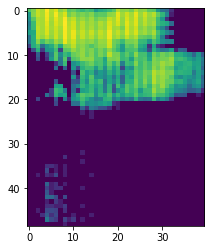

In [9]:
plt.imshow(np.reshape(rune_spec, [49, 40]))

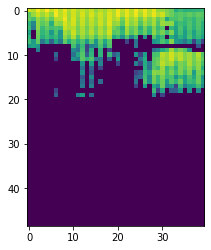

In [12]:
plt.imshow(np.reshape(test_data, [49, 40]))

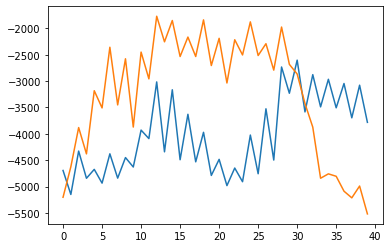

In [18]:
plt.plot(np.sum(np.reshape(test_data, [49, 40]), axis=0))
plt.plot(np.sum(np.reshape(rune_spec, [49, 40]), axis=0))

In [10]:
rune_result_list

[array([[-128, -123,  -52,   46]], dtype=int8),
 array([[-128,  -73, -105,   50]], dtype=int8),
 array([[-128,  117, -122, -123]], dtype=int8),
 array([[-128,   15, -123,  -19]], dtype=int8),
 array([[-128, -111,  108, -126]], dtype=int8)]

In [43]:
noise_filtering.even_smoothing = 0.025
noise_filtering.odd_smoothing = 0.06
noise_filtering.min_signal_remaining = 0.05
noise_filtering.strength = 0.95
noise_filtering.offset = 80.0
noise_filtering.gain_bits = 21

spectrum = fft(data)

In [47]:
spectrum.dtype

dtype('uint32')

(array([768.,   0.,  35.,  34.,  71., 159., 212., 393., 245.,  43.]),
 array([-128. , -103.3,  -78.6,  -53.9,  -29.2,   -4.5,   20.2,   44.9,
          69.6,   94.3,  119. ]),
 <BarContainer object of 10 artists>)

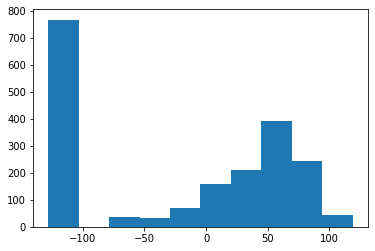

In [14]:
plt.hist(test_data.flatten())

# Compute performance with the original spectrogram, on all the yes/no files
# Compute performance with the spectrogram, on all the yes/no files

3941

In [4]:
!maturin develop --release

🔗 Found pyo3 bindings with abi3 support for Python ≥ 3.6
🐍 Not using a specific python interpreter (With abi3, an interpreter is only required on windows)
Traceback (most recent call last):
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/pip/_vendor/msgpack/__init__.py", line 14, in <module>
    from ._cmsgpack import Packer, unpackb, Unpacker
ModuleNotFoundError: No module named 'pip._vendor.msgpack._cmsgpack'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/meelislootus/.pyenv/versions/3.7.6/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/meelislootus/.pyenv/versions/3.7.6/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/pip/__main__.py", line 31, in <module>
    sys.exit(_main())
  Fi

In [2]:
WANTED_WORDS = "yles,alla,parem,vasak"
#DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'

DATA_URL = 'https://drive.google.com/uc?export=download&id=1uqR-_u3kxD3u64_MWAq9Gk2_lHT87Oqr' # Commands in Estonian
DATASET_DIR =  'recordings_wav/recordings_wav/recordings_wav'
    
#PREPROCESS = 'micro'
PREPROCESS = 'rune'

SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
WINDOW_STRIDE = 20
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.0 # 0.8
BACKGROUND_VOLUME_RANGE = 0.0 #0.1
TIME_SHIFT_MS = 100.0

model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS,
#    enable_pcan=False, min_signal_remaining=1.0,
    upper_mel_band_limit=7999.0,
    lower_mel_band_limit=0.0)

# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))

SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10
LOGS_DIR = 'logs/'
TRAIN_DIR = "train"

MODEL_ARCHITECTURE = 'tiny_conv'
#TRAINING_STEPS = "12000,3000"
#TRAINING_STEPS = "1200,300"
TRAINING_STEPS = "12,3"
LEARNING_RATE = "0.001,0.0001"

EVAL_STEP_INTERVAL = 1000
SAVE_STEP_INTERVAL = 1000

VERBOSITY = 'WARN'


audio_processor = input_data.AudioProcessor(DATA_URL, DATASET_DIR, SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
                                            WANTED_WORDS.split(','), VALIDATION_PERCENTAGE, TESTING_PERCENTAGE, 
                                            model_settings, LOGS_DIR)

params = {
      'data_url':DATA_URL,
      'data_dir':DATASET_DIR,
      'background_volume': 0.1, # How loud the background noise should be, between 0 and 1.
      'background_frequency':0.8,
      'silence_percentage':SILENT_PERCENTAGE,
      'unknown_percentage':UNKNOWN_PERCENTAGE,
      'time_shift_ms':TIME_SHIFT_MS,
      'testing_percentage':TESTING_PERCENTAGE,
      'validation_percentage':VALIDATION_PERCENTAGE,
      'sample_rate':SAMPLE_RATE,
      'clip_duration_ms':CLIP_DURATION_MS,
      'window_size_ms': WINDOW_SIZE_MS,
      'window_stride_ms':WINDOW_STRIDE,
      'feature_bin_count':FEATURE_BIN_COUNT,
      'how_many_training_steps':TRAINING_STEPS,
      'eval_step_interval':EVAL_STEP_INTERVAL,
      'learning_rate':LEARNING_RATE,
      'batch_size':16,
      'summaries_dir':LOGS_DIR,
      'wanted_words':WANTED_WORDS,
      'train_dir':TRAIN_DIR,
      'save_step_interval':SAVE_STEP_INTERVAL,
      'start_checkpoint':"",
      'model_architecture':MODEL_ARCHITECTURE,
      'check_nans':False,
      'quantize':True,
      'preprocess':PREPROCESS,
      'verbosity':VERBOSITY,
      'optimizer':'gradient_descent'}

OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [3]:
tf.__version__

'1.15.2'

In [ ]:
# Fix the data download part

In [9]:
from tensorflow.python.platform import gfile
from six.moves import xrange  # pylint: disable=redefined-builtin


def train(audio_processor, model_settings, params):

    tf.compat.v1.logging.set_verbosity(params["verbosity"])

    # Start a new TensorFlow session.
    sess = tf.compat.v1.InteractiveSession()

    fingerprint_size = model_settings['fingerprint_size']
    label_count = model_settings['label_count']
    time_shift_samples = int(
        (params["time_shift_ms"] * params["sample_rate"]) / 1000)
    # Figure out the learning rates for each training phase. Since it's often
    # effective to have high learning rates at the start of training, followed by
    # lower levels towards the end, the number of steps and learning rates can be
    # specified as comma-separated lists to define the rate at each stage. For
    # example --how_many_training_steps=10000,3000 --learning_rate=0.001,0.0001
    # will run 13,000 training loops in total, with a rate of 0.001 for the first
    # 10,000, and 0.0001 for the final 3,000.
    training_steps_list = list(
        map(int, params["how_many_training_steps"].split(',')))
    learning_rates_list = list(map(float, params["learning_rate"].split(',')))
    if len(training_steps_list) != len(learning_rates_list):
        raise Exception(
            '--how_many_training_steps and --learning_rate must be equal length '
            'lists, but are %d and %d long instead' % (len(training_steps_list),
                                                       len(learning_rates_list)))

    input_placeholder = tf.compat.v1.placeholder(
        tf.float32, [None, fingerprint_size], name='fingerprint_input')
    if params["quantize"]:
        fingerprint_min, fingerprint_max = input_data.get_features_range(
            model_settings)
        fingerprint_input = tf.quantization.fake_quant_with_min_max_args(
            input_placeholder, fingerprint_min, fingerprint_max)
    else:
        fingerprint_input = input_placeholder

    logits, dropout_rate = models.create_model(
        fingerprint_input,
        model_settings,
        params["model_architecture"],
        is_training=True)

    # Define loss and optimizer
    ground_truth_input = tf.compat.v1.placeholder(
        tf.int64, [None], name='groundtruth_input')

    # Optionally we can add runtime checks to spot when NaNs or other symptoms of
    # numerical errors start occurring during training.
    control_dependencies = []
    if params["check_nans"]:
        checks = tf.compat.v1.add_check_numerics_ops()
        control_dependencies = [checks]

    # Create the back propagation and training evaluation machinery in the graph.
    with tf.compat.v1.name_scope('cross_entropy'):
        cross_entropy_mean = tf.compat.v1.losses.sparse_softmax_cross_entropy(
            labels=ground_truth_input, logits=logits)

    if params["quantize"]:
        try:
            tf.contrib.quantize.create_training_graph(quant_delay=0)
        except AttributeError as e:
            msg = e.args[0]
            msg += ('\n\n The --quantize option still requires contrib, which is not '
                    'part of TensorFlow 2.0. Please install a previous version:'
                    '\n    `pip install tensorflow<=1.15`')
            e.args = (msg,)
            raise e

    with tf.compat.v1.name_scope('train'), tf.control_dependencies(
            control_dependencies):
        learning_rate_input = tf.compat.v1.placeholder(
            tf.float32, [], name='learning_rate_input')
        if params["optimizer"] == 'gradient_descent':
            train_step = tf.compat.v1.train.GradientDescentOptimizer(
                learning_rate_input).minimize(cross_entropy_mean)
        elif params["optimizer"] == 'momentum':
            train_step = tf.compat.v1.train.MomentumOptimizer(
                learning_rate_input, .9,
                use_nesterov=True).minimize(cross_entropy_mean)
        else:
            raise Exception('Invalid Optimizer')
    predicted_indices = tf.argmax(input=logits, axis=1)
    correct_prediction = tf.equal(predicted_indices, ground_truth_input)
    confusion_matrix = tf.math.confusion_matrix(labels=ground_truth_input,
                                                predictions=predicted_indices,
                                                num_classes=label_count)
    evaluation_step = tf.reduce_mean(input_tensor=tf.cast(correct_prediction,
                                                          tf.float32))
    with tf.compat.v1.get_default_graph().name_scope('eval'):
        tf.compat.v1.summary.scalar('cross_entropy', cross_entropy_mean)
        tf.compat.v1.summary.scalar('accuracy', evaluation_step)

    global_step = tf.compat.v1.train.get_or_create_global_step()
    increment_global_step = tf.compat.v1.assign(global_step, global_step + 1)

    saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())

    # Merge all the summaries and write them out to /tmp/retrain_logs (by default)
    merged_summaries = tf.compat.v1.summary.merge_all(scope='eval')
    train_writer = tf.compat.v1.summary.FileWriter(params["summaries_dir"] + '/train',
                                                   sess.graph)
    validation_writer = tf.compat.v1.summary.FileWriter(
        params["summaries_dir"] + '/validation')

    tf.compat.v1.global_variables_initializer().run()

    start_step = 1

    if params["start_checkpoint"]:
        models.load_variables_from_checkpoint(sess, params["start_checkpoint"])
        start_step = global_step.eval(session=sess)

    tf.compat.v1.logging.info('Training from step: %d ', start_step)

    # Save graph.pbtxt.
    tf.io.write_graph(sess.graph_def, params["train_dir"],
                      params["model_architecture"] + '.pbtxt')

    # Save list of words.
    with gfile.GFile(
            os.path.join(params["train_dir"],
                         params["model_architecture"] + '_labels.txt'),
            'w') as f:
        f.write('\n'.join(audio_processor.words_list))

    # Training loop.
    training_steps_max = np.sum(training_steps_list)
    for training_step in xrange(start_step, training_steps_max + 1):
        # Figure out what the current learning rate is.
        training_steps_sum = 0
        for i in range(len(training_steps_list)):
            training_steps_sum += training_steps_list[i]
            if training_step <= training_steps_sum:
                learning_rate_value = learning_rates_list[i]
                break
        # Pull the audio samples we'll use for training.
        train_fingerprints, train_ground_truth = audio_processor.get_data(
            params["batch_size"], 0, model_settings, params["background_frequency"],
            params["background_volume"], time_shift_samples, 'training', sess)
        # Run the graph with this batch of training data.
        train_summary, train_accuracy, cross_entropy_value, _, _ = sess.run(
            [
                merged_summaries,
                evaluation_step,
                cross_entropy_mean,
                train_step,
                increment_global_step,
            ],
            feed_dict={
                fingerprint_input: train_fingerprints,
                ground_truth_input: train_ground_truth,
                learning_rate_input: learning_rate_value,
                dropout_rate: 0.5
            })
        train_writer.add_summary(train_summary, training_step)
        tf.compat.v1.logging.debug(
            'Step #%d: rate %f, accuracy %.1f%%, cross entropy %f' %
            (training_step, learning_rate_value, train_accuracy * 100,
             cross_entropy_value))
        is_last_step = (training_step == training_steps_max)
        if (training_step % params["eval_step_interval"]) == 0 or is_last_step:
            tf.compat.v1.logging.info(
                'Step #%d: rate %f, accuracy %.1f%%, cross entropy %f' %
                (training_step, learning_rate_value, train_accuracy * 100,
                 cross_entropy_value))
            set_size = audio_processor.set_size('validation')
            total_accuracy = 0
            total_conf_matrix = None
            for i in xrange(0, set_size, params["batch_size"]):
                validation_fingerprints, validation_ground_truth = (
                    audio_processor.get_data(params["batch_size"], i, model_settings, 0.0,
                                             0.0, 0, 'validation', sess))
                # Run a validation step and capture training summaries for TensorBoard
                # with the `merged` op.
                validation_summary, validation_accuracy, conf_matrix = sess.run(
                    [merged_summaries, evaluation_step, confusion_matrix],
                    feed_dict={
                        fingerprint_input: validation_fingerprints,
                        ground_truth_input: validation_ground_truth,
                        dropout_rate: 0.0
                    })
                validation_writer.add_summary(
                    validation_summary, training_step)
                batch_size = min(params["batch_size"], set_size - i)
                total_accuracy += (validation_accuracy * batch_size) / set_size
                if total_conf_matrix is None:
                    total_conf_matrix = conf_matrix
                else:
                    total_conf_matrix += conf_matrix
            tf.compat.v1.logging.info(
                'Confusion Matrix:\n %s' % (total_conf_matrix))
            tf.compat.v1.logging.info('Step %d: Validation accuracy = %.1f%% (N=%d)' %
                                      (training_step, total_accuracy * 100, set_size))

        # Save the model checkpoint periodically.
        if (training_step % params["save_step_interval"] == 0 or
                training_step == training_steps_max):
            checkpoint_path = os.path.join(params["train_dir"],
                                           params["model_architecture"] + '.ckpt')
            tf.compat.v1.logging.info('Saving to "%s-%d"', checkpoint_path,
                                      training_step)
            saver.save(sess, checkpoint_path, global_step=training_step)

    set_size = audio_processor.set_size('testing')
    tf.compat.v1.logging.info('set_size=%d', set_size)
    total_accuracy = 0
    total_conf_matrix = None
    for i in xrange(0, set_size, params["batch_size"]):
        test_fingerprints, test_ground_truth = audio_processor.get_data(
            params["batch_size"], i, model_settings, 0.0, 0.0, 0, 'testing', sess)
        test_accuracy, conf_matrix = sess.run(
            [evaluation_step, confusion_matrix],
            feed_dict={
                fingerprint_input: test_fingerprints,
                ground_truth_input: test_ground_truth,
                dropout_rate: 0.0
            })
        batch_size = min(params["batch_size"], set_size - i)
        total_accuracy += (test_accuracy * batch_size) / set_size
        if total_conf_matrix is None:
            total_conf_matrix = conf_matrix
        else:
            total_conf_matrix += conf_matrix
    tf.compat.v1.logging.warn('Confusion Matrix:\n %s' % (total_conf_matrix))
    tf.compat.v1.logging.warn('Final test accuracy = %.1f%% (N=%d)' %
                              (total_accuracy * 100, set_size))
    

In [10]:
train(audio_processor, model_settings, params)

/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


ValueError: Variable first_weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/meelislootus/Documents/hotg/tflite_models/venv_tf1_py3d7d6/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)


In [7]:
model_settings["preprocess"]

'micro'